In [68]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

In [69]:
#
# Find outliers
# ndvi(t) is an outlier if:
# 1) abs(zscore) > 1.5 (relative to it's two neighbours on each side)
# 2) it is "far" away from the mean in absolute terms too, i.e.
#    ndvi(t) - mean > 0.2
#
def find_outliers(m2):
    # compure zscore for every point using two points before and two points after each point
    window_size = 7
    rolling_mean = m2['ndvi'].rolling(window=window_size, center=True).mean()
    rolling_std = m2['ndvi'].rolling(window=window_size, center=True).std()

    # Calculate the z-score for each point
    m2['rolling mean'] = rolling_mean
    m2['rolling std'] = rolling_std
    m2['zscore'] = (m2['ndvi'] - rolling_mean) / rolling_std
    m2['delta'] = m2['ndvi'] - m2['rolling mean']
    m2['outlier'] = (m2['delta'].abs() > 0.2) & (m2['zscore'].abs() > 1.5)
    return m2

# m is a dataframe with columns time and ndvi
def remove_outliers(m):
    m1 = m.copy()
    m1 = find_outliers(m1)
    m2 = m1[m1['outlier']==False]
    print(f"removed {m1.shape[0] - m2.shape[0]} outliers")
    y = pd.DataFrame()
    y['time'] = m2['time'].values
    y['ndvi'] = m2['ndvi'].values
    return y


In [70]:
# df_ is a dataframe where column 0 is time and column 1 is ndvi other colums are ignored
def savgol(df_,window_length=20,polyorder=2):
    # rename the first column as 'time' and the second as 'ndvi'
    m = pd.DataFrame()    
    m['time'] = df_.iloc[:,0]
    m['ndvi'] = df_.iloc[:,1]
    m = remove_outliers(m)
    min_date = m["time"].min()
    max_date = m["time"].max()
    date_range = pd.date_range(min_date, max_date, freq='D')
    m1 = pd.DataFrame({"time": date_range})

    # Merge the original 'ndvi' values into the new DataFrame 'm1' using outer join
    m1 = pd.merge(m1, m, on="time", how="left")

    # Interpolate missing values in the 'ndvi' column
    m1["ndvi"] = m1["ndvi"].interpolate()

    # Fill missing values with NaN, so the filter doesn't treat them as zeros
    m1["ndvi"] = m1["ndvi"].replace(0, np.nan)

    # Apply the savgol_filter to smooth the "ndvi" column
    m1["ndvi_smoothed"] = savgol_filter(m1["ndvi"], window_length, polyorder)

    # usefull for comparing savvol with original inputs
    # l = []
    # for t in m['time'].values:
    #     ndvi_value = m1[m1['time']==t]['ndvi_smoothed'].values[0]
    #     l.append(ndvi_value)
    # m['savgol point'] = l
    # return m1,m

    return m1

In [71]:
def load_ndvi_data():
    file_name = 'data/qa_queries_V28.parquet'
    df = pd.read_parquet(file_name)
    df = df.sort_values(by=['lat', 'time'])
    # slice off all rows where qa.sentinel2 == 1
    s2 = df[df['qa.sentinel2'] == 1].copy()
    # remove all columns except time, lat, ndvi.sentinel2
    s2 = s2[['time', 'lat', 'ndvi.sentinel2']]
    # rename ndvi.sentinel2 to ndvi
    s2 = s2.rename(columns={'ndvi.sentinel2': 'ndvi'})
    # remove any row where ndvi is the same as the previous row
    s2 = s2[s2['ndvi'] != s2['ndvi'].shift(1)]

    # slice off all rows where qa.landsat8 == 1
    l8 = df[df['qa.landsat'] == 1].copy()
    # remove all columns except time, lat, ndvi.landsat
    l8 = l8[['time', 'lat', 'ndvi.landsat']]
    # rename ndvi.landsat to ndvi
    l8 = l8.rename(columns={'ndvi.landsat': 'ndvi'})
    # remove any row where ndvi is the same as the previous row
    l8 = l8[l8['ndvi'] != l8['ndvi'].shift(1)]
    # concat s2 and l8
    m = pd.concat([s2, l8])
    # sort by lat, time
    m = m.sort_values(by=['lat', 'time'])
    # reset index
    m = m.reset_index(drop=True)

    # now lets get ndvi.streambatch
    # slice off all rows where ndvi.streambatch is not nan
    sb = df[df['ndvi.streambatch'].notnull()]
    # remove all columns except time, lat, ndvi.streambatch
    sb = sb[['time', 'lat', 'ndvi.streambatch']]
    # sort by lat, time
    sb = sb.sort_values(by=['lat', 'time'])
    # reset index
    sb = sb.reset_index(drop=True)
    return m, sb

raw_ndvi, streambatch_ndvi = load_ndvi_data()
streambatch_ndvi.head()


,time,lat,ndvi.streambatch
0,2013-04-20,-34.065146,0.000000
1,2013-04-21,-34.065146,0.000000
2,2013-04-22,-34.065146,0.448329
3,2013-04-23,-34.065146,0.449348
4,2013-04-24,-34.065146,0.459502


In [72]:
import matplotlib.pyplot as plt

def plot(fitted_ndvi,streambatch_ndvi,title):
    print(title)
    plt.scatter(fitted_ndvi['time'], fitted_ndvi['ndvi_smoothed'], label='savgol',s=5,color='blue')
    plt.scatter(streambatch_ndvi['time'], streambatch_ndvi['ndvi.streambatch'], label='ndvi.streambatch',s=5, color="red")
    plt.title(title)
    plt.legend()
    plt.ylim(0, 1.0)
    plt.show()

removed 1 outliers
lat=-34.065146, year=2020


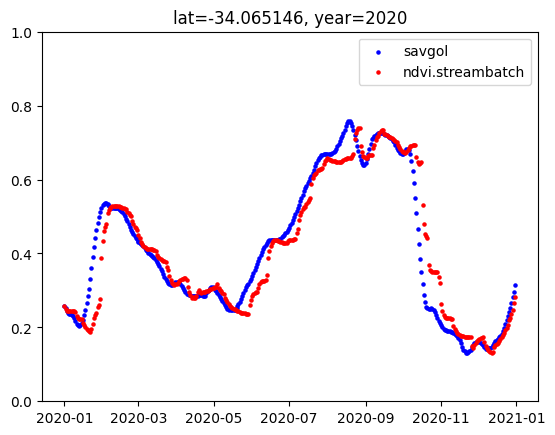

lat=-34.065146, year=2021


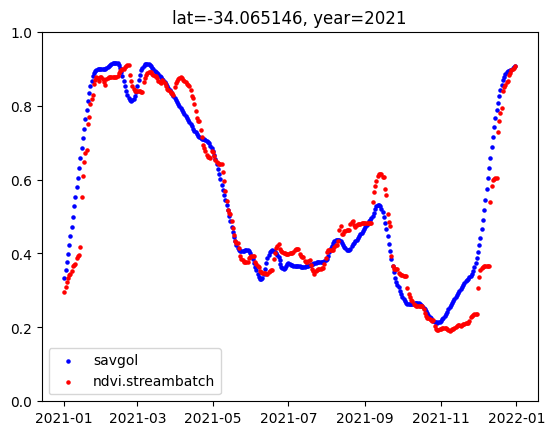

lat=-34.065146, year=2022


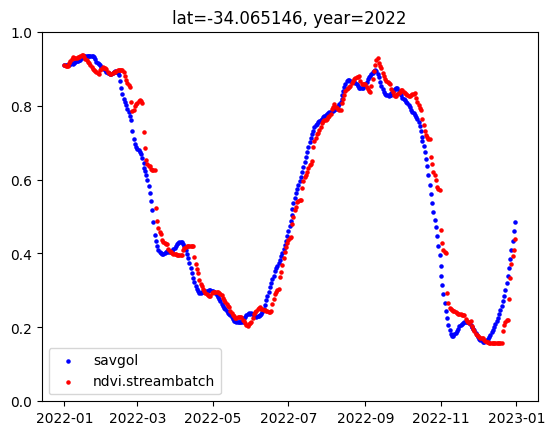

In [79]:
lats = m['lat'].unique()
lat = lats[0]


# start_date = '2020-01-01'
# end_date = '2020-12-31'
# fitted_time_slice = fitted[(fitted.time >= start_date) & (fitted.time <= end_date)]
# streambatch_time_slice = streambatch_ndvi_at_this_lat[(streambatch_ndvi_at_this_lat.time >= start_date) & (streambatch_ndvi_at_this_lat.time <= end_date)]
# plot(fitted_time_slice, streambatch_time_slice)

for lat in lats[0:22]:
    ndvi_at_this_lat = raw_ndvi[raw_ndvi.lat==lat]
    ndvi_at_this_lat = ndvi_at_this_lat[['time','ndvi']] # ditch the lat column
    fitted = savgol(ndvi_at_this_lat,window_length=20,polyorder=2)
    streambatch_ndvi_at_this_lat = streambatch_ndvi[streambatch_ndvi.lat==lat]
    streambatch_ndvi_at_this_lat = streambatch_ndvi_at_this_lat[['time','ndvi.streambatch']] # ditch the lat column
    for year in range(2020,2023):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'   
        fitted_time_slice = fitted[(fitted.time >= start_date) & (fitted.time <= end_date)]
        streambatch_time_slice = streambatch_ndvi_at_this_lat[(streambatch_ndvi_at_this_lat.time >= start_date) & (streambatch_ndvi_at_this_lat.time <= end_date)]
        title = f'lat={lat}, year={year}'
        plot(fitted_time_slice, streambatch_time_slice,title)

